In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import random

from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib

from tensorflow import keras
from tensorflow.python.keras import utils

from keras.utils import np_utils
from keras.models import load_model

import seaborn as sns
from datetime import datetime

from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

import os.path

import multiprocessing
import os
import time

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r5x65597 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Simulated Datasets (Multiclass Classification) Generation
- Normal distribution dataset
  - Data d (cluster_std=1), Data e (cluster_std=2), Data f (cluster_std=3)
- moon shape dataset
  - Data g (sigma=0.1), Data h (sigma=0.2), Data i (sigma=0.4)
- circle shape dataset  
  - Data m (factor=0.1, noise=0.6), Data n (factor=0.3, noise=0.7), Data o (factor=0.5, noise=0.8)

In [ ]:
def normal_distribution_data(n_samples,n_classes,cluster):
    colors = ['purple', 'yellow','green'] # Provide possible maximum number of classes
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    features, true_labels = make_blobs(n_samples=n_samples, n_features=2, centers=n_classes, cluster_std=cluster, random_state=45)
    d = {'x1': features[:,0], 'x2': features[:,1], 'label': true_labels}
    two_cl_data = pd.DataFrame(data=d)
    X_all = two_cl_data[['x1','x2']]
    y_all = two_cl_data['label']
    return(X_all,y_all)


def moon_shape(number_of_moons,sigma, radius, number_of_datapoints,y_shift):
    moons = []
    np.random.seed(45)
    for y in range(number_of_moons):
        q = np.random.uniform(0,np.pi,size=number_of_datapoints)
        if y % 2 == 0:
            factor = 1
        else:
            factor = -1

        moon = np.zeros((number_of_datapoints, 3))
        moon[:,0] = (radius * np.cos(q)) + y
        moon[:,1] = (radius * np.sin(q) * factor) + (factor == -1) * y_shift
        moon[:,2] = y
        moons.append(moon)
        noise = np.random.normal(0, sigma, size=moon[:,:2].shape)
        moon[:,:2] += noise
    moons = np.concatenate(moons)
    d = {'x1': moons[:,0], 'x2': moons[:,1], 'label': moons[:,2]}
    data = pd.DataFrame(data=d)
    X_all = data[['x1','x2']]
    y_all = data['label']
    return(X_all,y_all)


def three_circle_shape(f1,f2):
    X_small, y_small = make_circles(n_samples=(500,1000), random_state=3, noise=0.06, factor = f1)
    X_large, y_large = make_circles(n_samples=(500,1000), random_state=3, noise=0.06, factor = f2)
    y_large[y_large==1] = 2
    df = pd.DataFrame(np.vstack([X_small,X_large]),columns=['x1','x2'])
    df['label'] = np.hstack([y_small,y_large])
    X_all = df[['x1','x2']]
    y_all = df['label']
    return(X_all,y_all)

# Example code of running CDmc with Data l

In [ ]:
# File path
file_name = './(l)three_class_MS.xlsx'
excel_sheet_name = 'three_ms'
value = "number_of_neuron"
number_of_NNs = 20

In [ ]:
# Moon shape
three_ms_X,three_ms_y = moon_shape(number_of_moons=3,sigma=0.4, radius=1, number_of_datapoints=1000,y_shift = 0.3)
plt.title("Three Class Moon Shape" ,fontsize=20)
plt.scatter(three_ms_X['x1'], three_ms_X['x2'], c=three_ms_y)

'''
# Normal distribution
three_nd_X,three_nd_y = normal_distribution_data(n_samples=3000,n_classes=3,cluster=3)
'''

'''
# Circle shape
three_cs_X, three_cs_y = three_circle_shape(0.5,0.8)
'''

In [ ]:
# Load file
if os.path.isfile(file_name):
  wb = load_workbook(file_name, read_only=True)   # open the excel file and return a workbook
  if excel_sheet_name in wb.sheetnames:
    print(excel_sheet_name,'exist')
    number_of_index_done = pd.read_excel(file_name,sheet_name="two_nd",header=None)
    print(number_of_index_done)

    # column headers: index, x1, x2, y_labe, number of neuron, correct_predictions
    if len(number_of_index_done) == 0:
      starting = len(number_of_index_done)
      print("Starting index:",starting) # when the file is empty

    else:
      if len(number_of_index_done) == len(three_ms_X):
        print("All index generated")
        starting = None # The calculation process is done

      else:
        starting = number_of_index_done[0].iloc[-1]+1
        print("Starting index:",starting) # When the process is not done

  else:
    print("no sheet exist, generate")
    wb = load_workbook(file_name)
    wb.create_sheet(excel_sheet_name)
    wb.save(file_name)
    starting = 0

else:
  print("no file exist, generate")
  wb = Workbook()
  ws =  wb.active
  ws.title = excel_sheet_name
  wb.save(filename = file_name)
  starting = 0

sheet three_ms exist
         0         1         2  3   4   5
0        0 -0.228937 -0.740585  0  30   0
1        1  0.062869  0.329947  0   2  20
2        2  0.391317  0.548787  0   2  20
3        3  1.481452  0.076591  0  30   0
4        4  0.032415  1.519521  0   2  20
...    ...       ...       ... ..  ..  ..
2995  2995  0.967613  0.532663  2   5  18
2996  2996  1.059331  1.175767  2   2  20
2997  2997  1.634909  0.746387  2   2  20
2998  2998  1.272227  0.210761  2   5  19
2999  2999  2.891568  1.088483  2   2  20

[3000 rows x 6 columns]
All index generated


## Set: CDmc process (number of neuron in hidden layer = 1)

In [ ]:
# without manual generating of random seed, train_test_split makes identical datasets
def random_generater():
    return(random.randint(1, 100000))


def nn_model_complexity_multiprocessing(X, y, X_test, y_test,number_of_neuron):
    y = np_utils.to_categorical(y,3)

    count = 0
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_generater())

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(number_of_neuron, input_shape=(X_train.shape[1],), activation='relu')) # number of neuron in the hidden layer
    model.add(tf.keras.layers.Dense(3, activation='softmax')) #output layer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, verbose=0, callbacks=[es])
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Count how many correct predictions are made
    if y_pred == y_test:
        count += 1
    else:
        count +=0

    tf.keras.backend.clear_session()
    output.put(count)

In [ ]:
output = multiprocessing.Queue()
if __name__ == "__main__":
    rows = []
    start_time_overall = datetime.now()
    for i in range(starting, len(three_ms_X)):
        print("index:",i,"\n")
        start_time_one = datetime.now()

        X_all = three_ms_X
        y_all = three_ms_y

       # one sample being left out as test data
        X_test = X_all.iloc[[i]]
        y_test = y_all[i]

        # dataset wilthout the test cas
        X = X_all.drop(index=[i])
        y = y_all.drop(index=[i])

        correct_count = 0
        number_of_neuron = 1 # number of neuron in the hidden layer
        NNs = 0

        processes = []
        for NNs in range(number_of_NNs): #How many NNs to generate
            p = multiprocessing.Process(target=nn_model_complexity_multiprocessing, args=(X, y, X_test, y_test,number_of_neuron))
            p.start()
            processes.append(p)

        try:
            for process in processes:
                process.join()

        except KeyboardInterrupt:
            print("parent received ctrl-c")
            for process in processes:
                process.terminate()
                process.join()

        # Get process results
        correct_count = [output.get() for p in processes]
        print("correct number:",sum(correct_count))
        rows.append([i,X_test['x1'].iloc[0],X_test['x2'].iloc[0],y_test,number_of_neuron,sum(correct_count)])
        score = pd.DataFrame(rows,columns=["case_index",'X1','X2','y',"number_of_neuron","correct_count"])
        print(i,'\n')

        end_time_one = datetime.now()
        print("one case_running_time:",end_time_one-start_time_one)

end_time_overall = datetime.now()
print("overall_running_time:",end_time_overall-start_time_overall)

TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
print(score)
three_ms = score
wb = load_workbook(filename=file_name)
ws = wb['three_ms']

for r in dataframe_to_rows(three_ms, index=False, header=False):
  ws.append(r)
wb.save(file_name)

     case_index        X1        X2    y  number_of_neuron  correct_count
0          2866  2.550795  0.998387  2.0                 1              2
1          2867  1.284488  0.817746  2.0                 1              1
2          2868  1.580566  0.344411  2.0                 1             17
3          2869  1.028380  0.242759  2.0                 1             18
4          2870  1.038366  0.052802  2.0                 1              0
..          ...       ...       ...  ...               ...            ...
129        2995  0.967613  0.532663  2.0                 1             12
130        2996  1.059331  1.175767  2.0                 1              3
131        2997  1.634909  0.746387  2.0                 1              1
132        2998  1.272227  0.210761  2.0                 1             17
133        2999  2.891568  1.088483  2.0                 1              1

[134 rows x 6 columns]


      index        x1        x2  y  number_of_neuron  correct_count
0         0 -0.228937 -0.740585  0                 1              6
1         1  0.062869  0.329947  0                 1              8
2         2  0.391317  0.548787  0                 1              6
3         3  1.481452  0.076591  0                 1              6
4         4  0.032415  1.519521  0                 1              8
...     ...       ...       ... ..               ...            ...
2995   2995  0.967613  0.532663  2                 1             12
2996   2996  1.059331  1.175767  2                 1              3
2997   2997  1.634909  0.746387  2                 1              1
2998   2998  1.272227  0.210761  2                 1             17
2999   2999  2.891568  1.088483  2                 1              1

[3000 rows x 6 columns]


Text(0.5, 1.0, 'two_ms_nn_complexity')

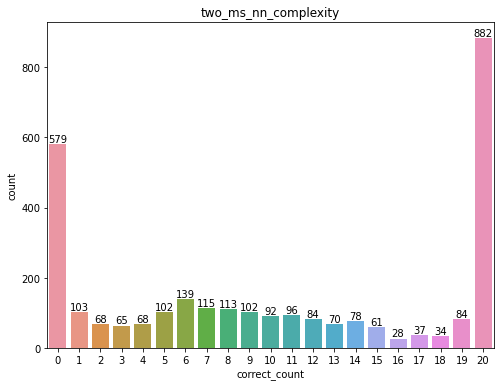

In [ ]:
# visuazlie the current result
data_for_visualize = pd.read_excel(file_name, sheet_name="three_ms", header=None, names=["index", "x1", "x2", "y","number_of_neuron","correct_count"])
print(data_for_visualize)

plt.figure(figsize=(8,6))
ax = sns.countplot(x=data_for_visualize["correct_count"])
ax.bar_label(ax.containers[0])
ax.set_title('two_ms_nn_complexity')

## Add: CDmc process (increasing number of neuron in hidden layer) with pool
- Need to run when CDmc process (number of neuron in hidden layer = 1) is done

In [ ]:
# load the result of set (must be completed)
# when the path or name of result file is different, need to modify the code
file_name = './(l)three_class_MS.xlsx'

#same variables with set
excel_sheet_name = 'three_ms'
value = "number_of_neuron"
number_of_NNs = 20
three_ms_X,three_ms_y = moon_shape(number_of_moons=3,sigma=0.4, radius=1, number_of_datapoints=1000,y_shift = 0.3)

# setting number of MNN
MNN = round(len(three_ms_X)*0.01)

      case_index        X1        X2  y  number_of_neuron  correct_count
0              0 -0.228937 -0.740585  0                30              0
1              1  0.062869  0.329947  0                 2             20
2              2  0.391317  0.548787  0                 2             20
3              3  1.481452  0.076591  0                30              0
4              4  0.032415  1.519521  0                 2             20
...          ...       ...       ... ..               ...            ...
2995        2995  0.967613  0.532663  2                 5             18
2996        2996  1.059331  1.175767  2                 2             20
2997        2997  1.634909  0.746387  2                 2             20
2998        2998  1.272227  0.210761  2                 5             19
2999        2999  2.891568  1.088483  2                 2             20

[3000 rows x 6 columns]
Ready to check the number of neuron


In [ ]:
# check the set is done
if os.path.isfile(file_name):
    wb = load_workbook(file_name, read_only=True)
    if excel_sheet_name in wb.sheetnames:
        number_of_index_done = pd.read_excel(file_name, sheet_name=excel_sheet_name, header=None, names=["case_index",'X1','X2','y',"number_of_neuron","correct_count"])
        print(number_of_index_done)

        if len(number_of_index_done) == 0:
            sys.exit("Error: number of index is zero.") # need to check the file, file is empty
        else:
            if len(number_of_index_done) == len(three_ms_X):
              print('Ready to check the number of neuron')
            else:
                sys.exit('Error: number of index is not enough.') # need to check the file, file does not match the number of original data
    else:
        print('no sheet exist')
        sys.exit("no sheet exist.")
else:
    print("no file exist")
    sys.exit("no file exist.")

In [ ]:
# without manual generating of random seed, train_test_split makes identical datasets
def random_generater():
    return(random.randint(1, 100000))

def nn_model_complexity_multiprocessing(X_train, X_val, y_train, y_val, X_test, y_test):
    y_train = np_utils.to_categorical(y_train,3)
    y_val = np_utils.to_categorical(y_val,3)
    model = load_model('model_l.h5')
    count = 0

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, verbose=0, callbacks=[es])
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Count how many correct predictions are made
    if y_pred == y_test:
        count += 1
    else:
        count +=0
    return count


while True:
    start_time_overall = datetime.now()
    updated_rows = []
    score = []

    one_neuron_file = pd.read_excel(file_name, sheet_name="three_ms", header=None, names=["case_index",'X1','X2','y',"number_of_neuron","correct_count"])
    X_all = one_neuron_file.drop(columns=['case_index', 'y', 'number_of_neuron', 'correct_count'])
    y_all = one_neuron_file['y']

    # Check the index that needs to be repeated
    repeat_index_count_view = one_neuron_file.loc[(one_neuron_file["number_of_neuron"] < MNN)&(one_neuron_file["correct_count"] < number_of_NNs*0.9),["case_index","number_of_neuron"]]
    print("repeat_index_count_view:",len(repeat_index_count_view),"\n")
    print(repeat_index_count_view,"\n")

    # Check the index that needs to be repeated with the certain number of neuron in the hidden layer
    number_of_neuron = repeat_index_count_view['number_of_neuron'].min()
    repeat_index_neuron_count_view = repeat_index_count_view.loc[(one_neuron_file["number_of_neuron"] <= number_of_neuron),["case_index","number_of_neuron"]]
    print("repeat_index_neuron_count_view:",len(repeat_index_neuron_count_view),"\n")
    print("repeat_index_neuron_count_view",repeat_index_neuron_count_view,"\n")

    number_of_neuron += 1

    if(len(repeat_index_neuron_count_view) == 0):
        break;

    else:
        for i in repeat_index_neuron_count_view["case_index"].values.tolist():
            start_time_one = datetime.now()

            # one sample being left out as test data
            X_test = X_all.iloc[[i]]
            y_test = y_all[i]

            # dataset wilthout the test case
            X = X_all.drop(index=[i])
            y = y_all.drop(index=[i])

            X_train_dataset = []
            X_val_dataset = []
            y_train_dataset = []
            y_val_dataset = []

            # Generate the groups of train and validatiaon set
            for nn in range(number_of_NNs):
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_generater())
                X_train_dataset.append(X_train)
                X_val_dataset.append(X_val)
                y_train_dataset.append(y_train)
                y_val_dataset.append(y_val)


            print("number_of_neuron:",number_of_neuron)
            model = tf.keras.models.Sequential()
            model.add(tf.keras.layers.Dense(number_of_neuron, input_shape=(2,), activation='relu')) #Increasing number of neuron
            model.add(tf.keras.layers.Dense(3, activation='softmax')) #output layer
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.save('model_l.h5')

            # Create a list of argument tuples
            arg_list = [(X_train_dataset[mm], X_val_dataset[mm], y_train_dataset[mm], y_val_dataset[mm]
                         ,X_test,y_test) for mm in range(number_of_NNs)]

            try:
                pool = multiprocessing.dummy.Pool()
                results = [pool.apply_async(nn_model_complexity_multiprocessing, args) for args in arg_list]
                print(results)
                correct_count = [r.get() for r in results]

            except KeyboardInterrupt:
                pool.terminate()
                pool.join()

            print("\n\nindex",i, "correct number:",sum(correct_count),"\n\n")

            end_time_one = datetime.now()
            print("one case_running_time:",end_time_one-start_time_one,"\n")

            updated_rows.append([i,X_test['x1'].iloc[0],X_test['x2'].iloc[0],y_test,number_of_neuron,sum(correct_count)])
            score = pd.DataFrame(updated_rows,columns=["case_index",'X1','X2','y',"number_of_neuron","correct_count"])


            result = pd.concat([one_neuron_file, score]).drop_duplicates(['case_index'], keep='last').sort_values('case_index')

            writer = pd.ExcelWriter(file_name)
            result.to_excel(writer, sheet_name = 'three_ms',header=None,index=False)
            writer.save()


        end_time_overall = datetime.now()
        print("overall_running_time:",end_time_overall-start_time_overall)

repeat_index_count_view: 35 

      case_index  number_of_neuron
2696        2696                29
2711        2711                29
2717        2717                29
2727        2727                29
2755        2755                29
2778        2778                29
2800        2800                29
2821        2821                29
2841        2841                29
2846        2846                29
2865        2865                29
2870        2870                29
2872        2872                29
2876        2876                29
2878        2878                29
2879        2879                29
2882        2882                29
2885        2885                29
2896        2896                29
2899        2899                29
2902        2902                29
2906        2906                29
2909        2909                29
2913        2913                29
2915        2915                29
2920        2920                29
2929        2929         

2023-01-10 15:58:35.556948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)




index 2696 correct number: 0 


one case_running_time: 0:00:49.188896 

number_of_neuron: 30
[<multiprocessing.pool.ApplyResult object at 0x7fb110541850>, <multiprocessing.pool.ApplyResult object at 0x7fb1104870a0>, <multiprocessing.pool.ApplyResult object at 0x7fb110487400>, <multiprocessing.pool.ApplyResult object at 0x7fb1104873a0>, <multiprocessing.pool.ApplyResult object at 0x7fb110487250>, <multiprocessing.pool.ApplyResult object at 0x7fb11043cc70>, <multiprocessing.pool.ApplyResult object at 0x7fb11043cbe0>, <multiprocessing.pool.ApplyResult object at 0x7fb11043cac0>, <multiprocessing.pool.ApplyResult object at 0x7fb11043c970>, <multiprocessing.pool.ApplyResult object at 0x7fb11043c850>, <multiprocessing.pool.ApplyResult object at 0x7fb11043c670>, <multiprocessing.pool.ApplyResult object at 0x7fb11043cca0>, <multiprocessing.pool.ApplyResult object at 0x7fb11043c700>, <multiprocessing.pool.ApplyResult object at 0x7fb11043c760>, <multiprocessing.pool.ApplyResult object at 0x7fb1

      index        x1        x2  y  number_of_neuron  correct_count
0         0 -0.228937 -0.740585  0                30              0
1         1  0.062869  0.329947  0                 2             20
2         2  0.391317  0.548787  0                 2             20
3         3  1.481452  0.076591  0                30              0
4         4  0.032415  1.519521  0                 2             20
...     ...       ...       ... ..               ...            ...
2995   2995  0.967613  0.532663  2                 5             18
2996   2996  1.059331  1.175767  2                 2             20
2997   2997  1.634909  0.746387  2                 2             20
2998   2998  1.272227  0.210761  2                 5             19
2999   2999  2.891568  1.088483  2                 2             20

[3000 rows x 6 columns]


Text(0.5, 1.0, 'three_ms_nn_complexity')

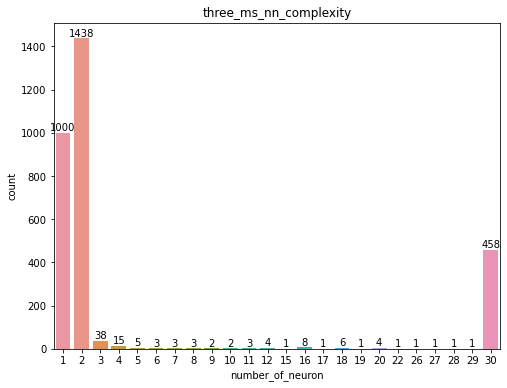

In [ ]:
# visuazlie the current result
data_for_visualize = pd.read_excel(file_name, sheet_name="three_ms", header=None, names=["index", "x1", "x2", "y","number_of_neuron","correct_count"])
print(data_for_visualize)

plt.figure(figsize=(8,6))
ax = sns.countplot(x=data_for_visualize[value])
ax.bar_label(ax.containers[0])
ax.set_title('three_ms_nn_complexity')

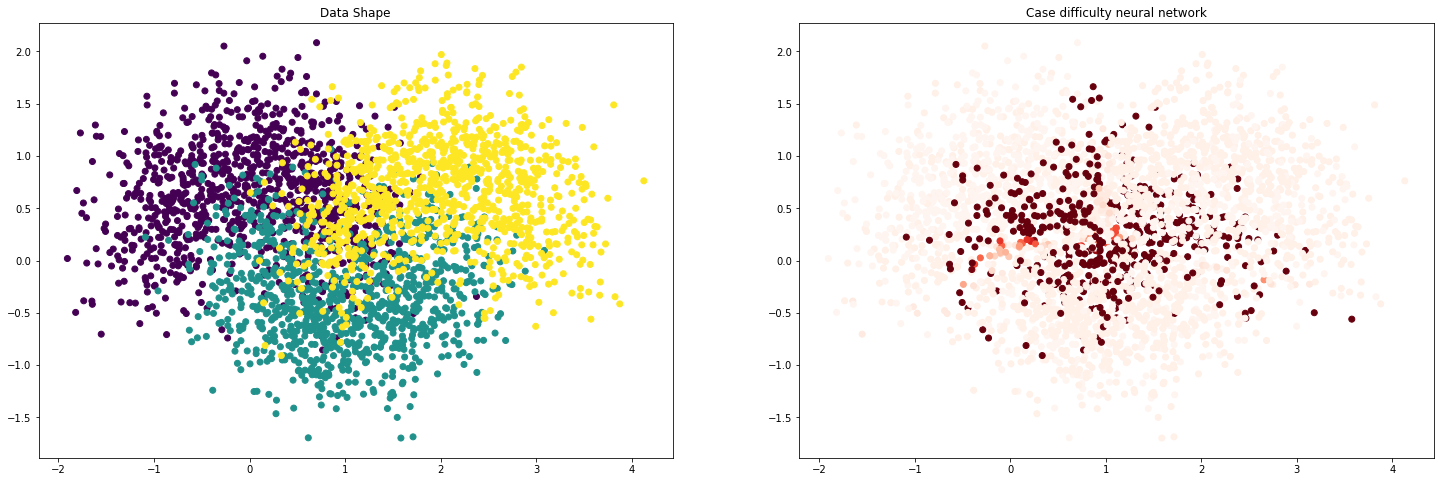

In [ ]:
# Comparision between the data shape and the case difficulty values
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

ax[0].set(title='Data Shape')
ax[1].set(title='Case difficulty neural network')


three_ms_nn_complexity = pd.read_excel(file_name, sheet_name="three_ms", header=None, names=["index", "x1", "x2", "y","number_of_neuron","correct_count"])
ax[0].scatter(three_ms_nn_complexity['x1'],three_ms_nn_complexity['x2'], c=three_ms_nn_complexity['y'])
ax[1].scatter(three_ms_nn_complexity['x1'], three_ms_nn_complexity['x2'], c=three_ms_nn_complexity["number_of_neuron"], cmap='Reds')